## Basic Model

Based on: https://github.com/ChristianMarzahl/ObjectDetection/blob/master/examples/CocoTiny_Retina_Net.ipynb

In [37]:
import os
import math
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor, tensor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

from fastai.core import is_tuple
from fastai.train import ShowGraph
from fastai.vision import Path, open_image, ImageBBox, ObjectItemList, get_transforms, bb_pad_collate, conv_layer, Learner, create_body, models, conv2d, ifnone, DatasetType, range_of, progress_bar

In [38]:
#from RetinaNet.object_detection_helper import 
from RetinaNet.object_detection_helper import create_anchors, show_results_side_by_side, get_annotations_from_path
from RetinaNet.RetinaNetFocalLoss import FocalLoss
from RetinaNet.RetinaNet import RetinaNet
from RetinaNet.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [39]:
DATA = Path('data/')
IMAGES = DATA/'train_labelled_images'
ANNOTATIONS = DATA/'train_labelled_annotations'

In [40]:
images, lbl_bbox = get_annotations_from_path(ANNOTATIONS, IMAGES)
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[IMAGES/o.name]

In [41]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_rand_pct(0.1)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)

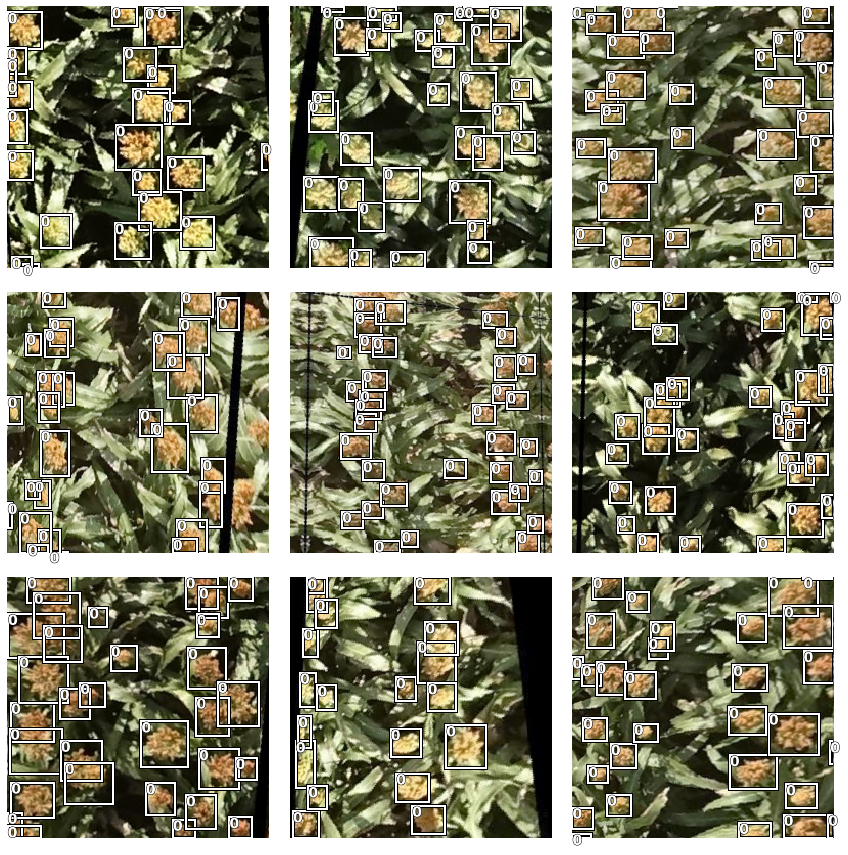

In [42]:
batch_size = 64
image_size = 256

data = get_data(batch_size, image_size)
data.show_batch(3)

In [43]:
#WARNING: Hardcoded anchor sizes probably not great for when we change things
anchors = create_anchors(sizes=[(16,16),(8,8),(4,4),(2,2)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 1])

In [44]:
n_classes = data.train_ds.c

crit = FocalLoss(anchors)

encoder = create_body(models.resnet101, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=9, sizes=[16,8,4,2], chs=32, final_bias=-4., n_conv=2)
#model.eval()

In [45]:
voc = PascalVOCMetric(anchors, image_size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [46]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.836172,2.025783,0,0.537909,1.487874,0,00:05
1,2.235713,1.888415,0,0.566829,1.321586,0,00:05
2,1.907627,1.528865,0.026619,0.517175,1.011690,0.026619,00:05
3,1.694978,1.297783,0.033036,0.503953,0.793830,0.033036,00:06
4,1.556884,1.301248,0.029532,0.512388,0.788860,0.029532,00:06
5,1.467114,1.288821,0.048212,0.520464,0.768358,0.048212,00:06
6,1.397290,1.260850,0.040628,0.510907,0.749943,0.040628,00:06
7,1.358577,1.481883,0.036744,0.514302,0.967581,0.036744,00:05
8,1.337062,1.418543,0.056816,0.510553,0.907990,0.056816,00:06
9,1.310006,1.320748,0.049277,0.501856,0.818892,0.049277,00:06


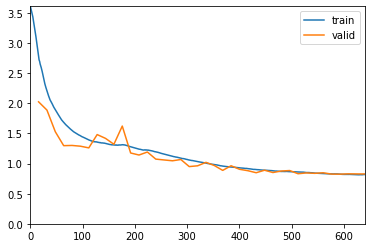

In [47]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,0.801644,0.843745,0.227501,0.366143,0.477602,0.227501,00:05
1,0.800371,0.823710,0.251268,0.367715,0.455995,0.251268,00:05
2,0.798365,0.831634,0.237545,0.362670,0.468964,0.237545,00:06
3,0.800916,0.814368,0.255912,0.364931,0.449438,0.255912,00:05
4,0.797366,0.814127,0.258873,0.358764,0.455362,0.258873,00:05
5,0.797534,0.820523,0.254727,0.368864,0.451659,0.254727,00:06
6,0.796324,0.817444,0.252907,0.364195,0.453249,0.252907,00:05
7,0.795284,0.814941,0.258968,0.360807,0.454134,0.258968,00:06
8,0.790885,0.800398,0.267128,0.357843,0.442555,0.267128,00:06
9,0.786572,0.799647,0.254388,0.355137,0.444510,0.254388,00:06


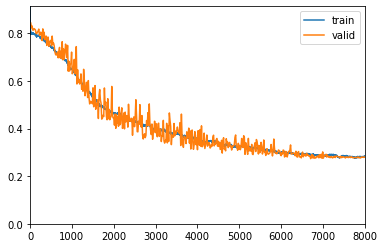

In [48]:
learn.unfreeze()
learn.fit_one_cycle(500, slice(1e-4, 1e-3))

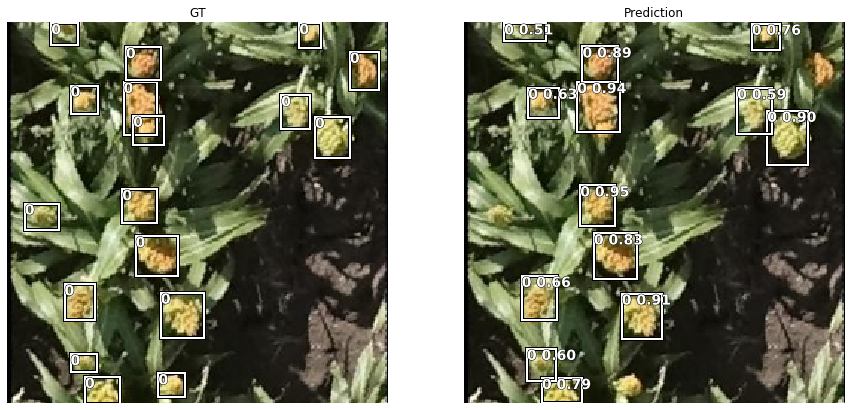

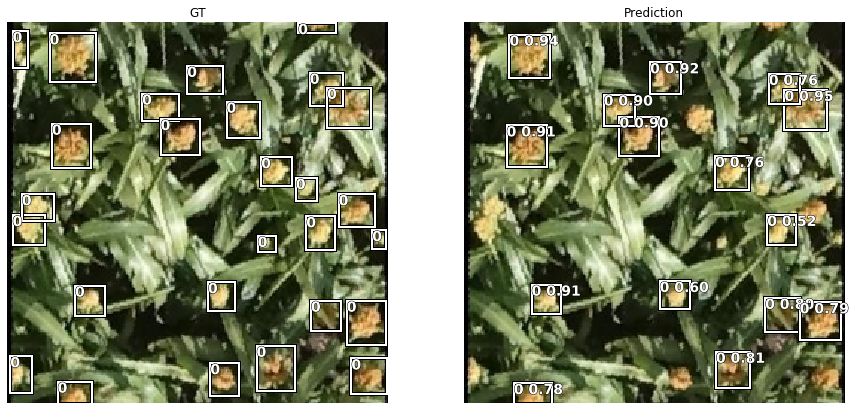

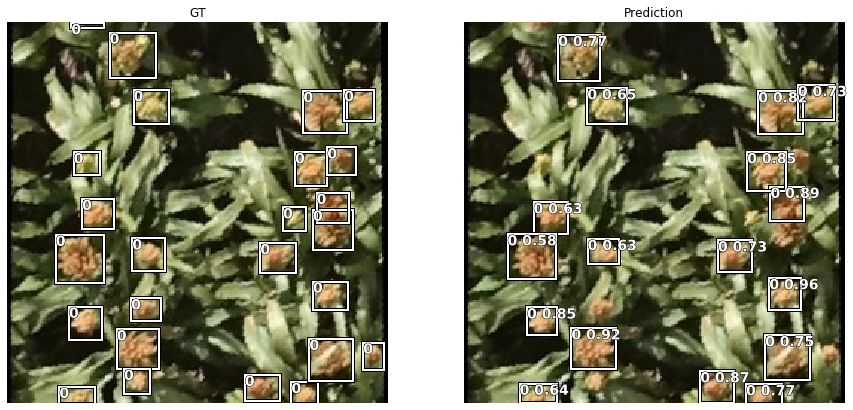

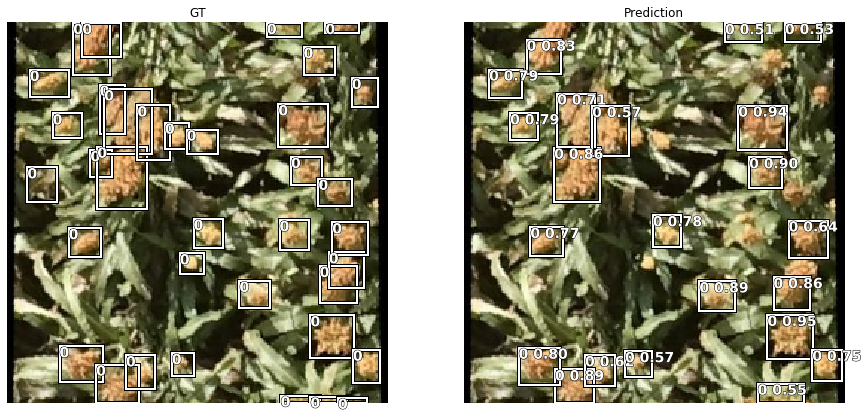

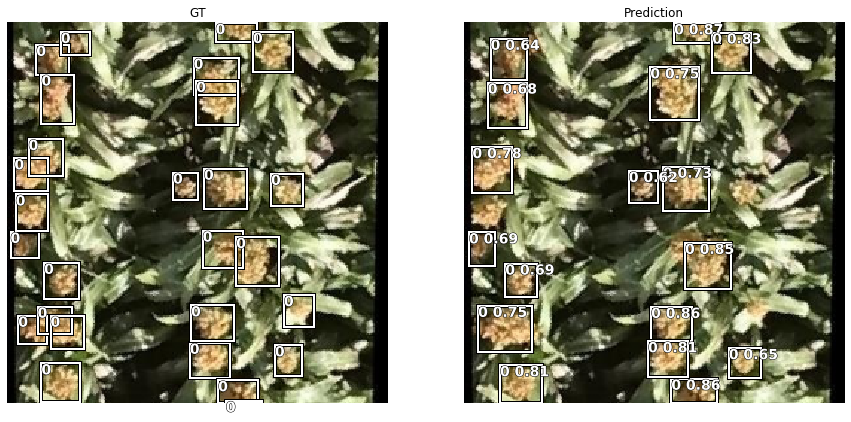

In [49]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=5)